### Challenge Intermedio: Modelado con Spark ML
##### Angel Samuel Romero Hernandez

In [ ]:
!pip install seaborn

In [1]:
# Análisis y Modelo de Regresión Logística para Predecir la Calidad del Vino
# =========================================================================

# ## Introducción
# Este notebook está diseñado para cargar, explorar y preprocesar el dataset de calidad de vinos, y entrenar un modelo de regresión logística utilizando PySpark en un entorno de Databricks.

# ## 1. Configuración de Databricks y Bibliotecas
# Importamos las bibliotecas necesarias y configuramos la conexión con Databricks.

import sys
sys.executable

import findspark
findspark.init()

import pandas as pd
import pyspark

import pandas as pd
import numpy as np
#import pyspark.pandas as ps
from pyspark.sql import SparkSession
import matplotlib as plt
import seaborn as sns
from pyspark.sql.functions import col, sum



from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


In [2]:

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('WineQualityPrediction')\
        .getOrCreate()

spark

In [3]:
# ## 2. Carga de Datos
# Cargamos el archivo CSV con los datos del vino y revisamos las primeras filas.

# Cargar el archivo CSV

gt = spark.read.csv('winequality-red.csv', 
                       inferSchema = True,
                       sep=";", 
                       header = True)
gt.printSchema()
gt.show(10)

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|          

In [4]:
print(type(gt))

<class 'pyspark.sql.dataframe.DataFrame'>


In [5]:
df = gt
df

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

In [6]:
# Convertir la columna "quality" a una variable binaria en una columna llamada "label"

df = df.withColumn("label", (col("quality") >= 6).cast("int"))
df.select("quality", "label").groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  855|
|    0|  744|
+-----+-----+



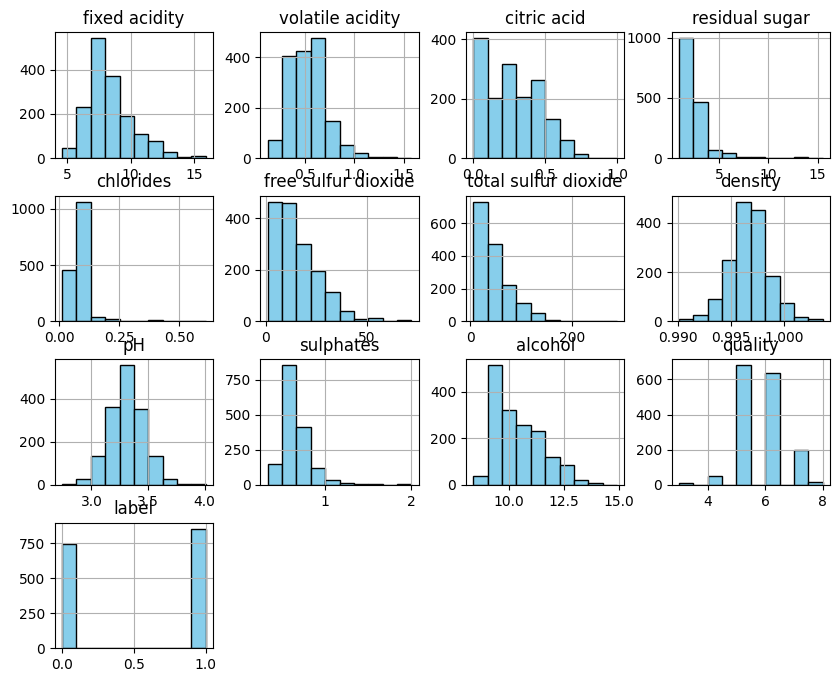

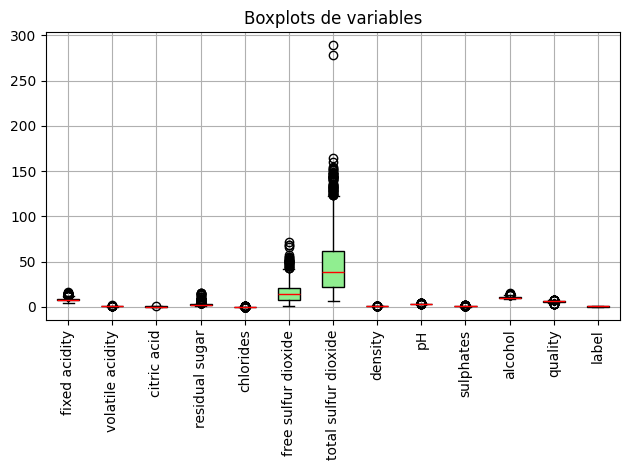

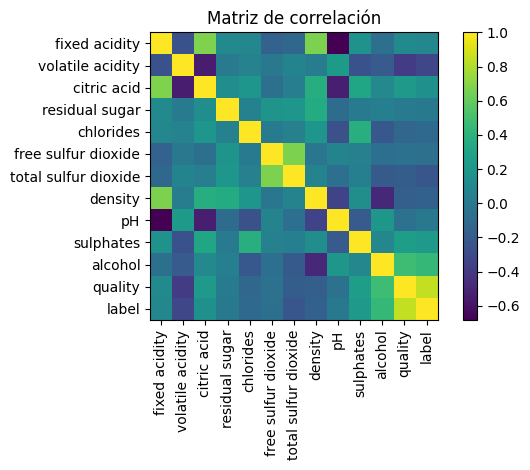

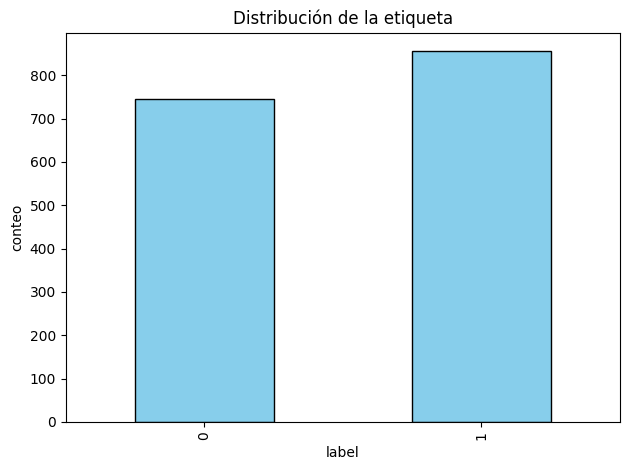

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
pdf = df.toPandas()

# 4.1 Histogramas con color
ax = pdf.hist(figsize=(10, 8), color='skyblue', edgecolor='black')
plt.show()

# 4.2 Boxplots con color
plt.figure()
pdf.boxplot(rot=90, patch_artist=True,
            boxprops=dict(facecolor='lightgreen'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
plt.title("Boxplots de variables")
plt.tight_layout()
plt.show()

# 4.3 Matriz de correlación (solo numéricas)
plt.figure()
corr = pdf.corr(numeric_only=True)
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

# 4.4 Distribución de la etiqueta con el mismo estilo de color

plt.figure()
pdf['label'].value_counts().sort_index().plot(
    kind='bar',
    color='skyblue',
    edgecolor='black'
)
plt.title("Distribución de la etiqueta")
plt.xlabel("label")
plt.ylabel("conteo")
plt.tight_layout()
plt.show()


In [9]:
# Selección de características

feature_columns = [c for c in df.columns if c not in ["quality", "label"]]
feature_columns

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [10]:
# Ensamblaje de las características en un solo vector

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)
df

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int, label: int, features: vector]

In [11]:
# Estandarización de las características

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)
df

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int, label: int, features: vector, scaledFeatures: vector]

In [12]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
train_data.count(), test_data.count()

(1324, 275)

In [13]:
# Entrenar el modelo de regresión logística
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label")
lr_model = lr.fit(train_data)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200)
rf_model = rf.fit(train_data)


In [14]:
# ## 6. Evaluación del Modelo

# Realizar predicciones en el conjunto de prueba
predictions = lr_model.transform(test_data)
pred_rf = rf_model.transform(test_data)

predictions.select("label", "prediction", "probability").show(5, truncate=False)
pred_rf.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|1    |1.0       |[0.01812103566953566,0.9818789643304643] |
|1    |1.0       |[0.25500976345328447,0.7449902365467156] |
|0    |0.0       |[0.7950894967723647,0.20491050322763527] |
|0    |0.0       |[0.7639910242923188,0.2360089757076812]  |
|1    |1.0       |[0.048145190017369395,0.9518548099826306]|
+-----+----------+-----------------------------------------+
only showing top 5 rows

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|1    |1.0       |[0.12195210444546092,0.878047895554539] |
|1    |1.0       |[0.20846250213565257,0.7915374978643474]|
|0    |1.0       |[0.3087229221856336,0.6912770778143664] |
|0    |0.0       |[0.6558665017572356,0.3441334982427644] |
|1    

In [15]:
# Evaluador para medir el área bajo la curva ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print(f"Evaluator: {evaluator}")
roc_auc = evaluator.evaluate(predictions)
roc_auc_rf = evaluator.evaluate(pred_rf)
print(f"Área bajo la curva ROC: {roc_auc:.2f}")
print(f"ROC RF: {roc_auc_rf:.2f}")

Evaluator: BinaryClassificationEvaluator_222adb3d18c8
Área bajo la curva ROC: 0.84
ROC RF: 0.86


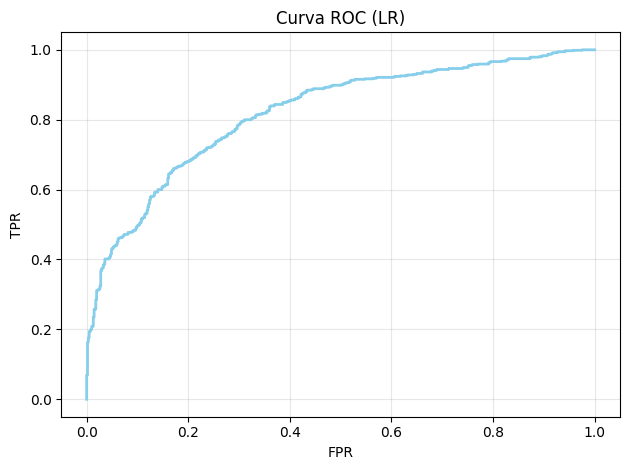

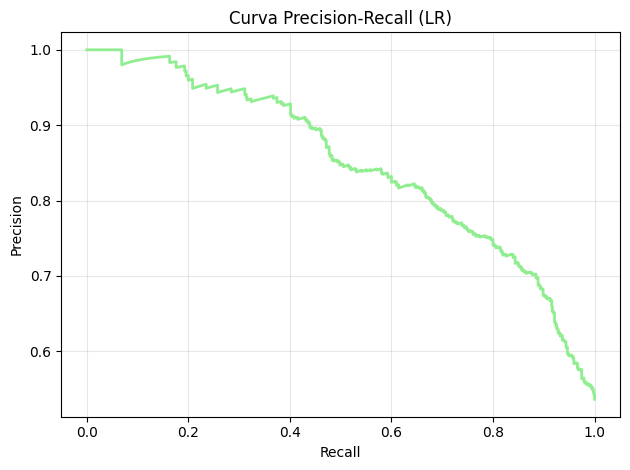

In [24]:
# Curvas ROC y PR (LR)

train_summary = lr_model.summary
roc_df = train_summary.roc.toPandas()
pr_df = train_summary.pr.toPandas()

# ROC
plt.figure()
plt.plot(roc_df['FPR'], roc_df['TPR'], color='skyblue', linewidth=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC (LR)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# PR
plt.figure()
plt.plot(pr_df['recall'], pr_df['precision'], color='lightgreen', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (LR)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Calcular la precisión y mostrar el informe de clasificación
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
print(f"evaluator_accuracy: {evaluator_accuracy}")
accuracy = evaluator_accuracy.evaluate(predictions)
print(f"Exactitud del modelo: {accuracy:.2f}")

evaluator_accuracy: MulticlassClassificationEvaluator_07e8391eda2e
Exactitud del modelo: 0.77


In [18]:
# Mostrar una muestra de las predicciones
predictions.select("label", "prediction", "probability").show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.01812103566953...|
|    1|       1.0|[0.25500976345328...|
|    0|       0.0|[0.79508949677236...|
|    0|       0.0|[0.76399102429231...|
|    1|       1.0|[0.04814519001736...|
+-----+----------+--------------------+
only showing top 5 rows

